In [1]:
import zipfile
import os

# Define file paths
zip_path = 'data/reaction_time_data.zip' # If you've put your file in the same directory as the notebook you're working in, your path is just the file name. If not, you'll need to include the path to the file.
extract_path = 'data' # This will extract the files to the current directory

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [2]:
import pandas as pd
import glob
import os

# Path to the directory containing extracted .csv files
csv_files = glob.glob(os.path.join(extract_path, '*.csv'))

# Initialize an empty list to store DataFrames
dfs = []

# Loop through and read each csv file
for idx, file in enumerate(csv_files):
    data = pd.read_csv(file)

    # Extract relevant rows and columns
    # Filter rows where 'trial_type' is 'response' (indicating a reaction time trial)
    data = data[data['trial_type'] == 'image-keyboard-response']

    # Select and rename relevant columns
    df = data[['rt', 'stimulus', 'response', 'correct']].copy()
    df.rename(columns={
        'rt': 'reaction_time',
        'stimulus': 'circle_color',
        'response': 'key_pressed',
        'correct': 'accuracy'
    }, inplace=True)

    # Clean up 'circle_color' to extract only color names
    df['circle_color'] = df['circle_color'].str.extract(r'images/(\w+).png')[0]

    # Add subject_id column
    df['subject_id'] = idx + 1

    # Reorder columns to make 'subject_id' the first column
    df = df[['subject_id', 'reaction_time', 'circle_color', 'key_pressed', 'accuracy']]

    # Append the processed DataFrame
    dfs.append(df)

# Concatenate all DataFrames
all_data = pd.concat(dfs, ignore_index=True)


In [3]:
import numpy as np
np.shape(all_data)

(1100, 5)

In [4]:
all_data.head()

,subject_id,reaction_time,circle_color,key_pressed,accuracy
0,1,445.0,orange,j,True
1,1,386.0,blue,f,True
2,1,366.0,blue,f,True
3,1,374.0,orange,j,True
4,1,409.0,orange,j,True


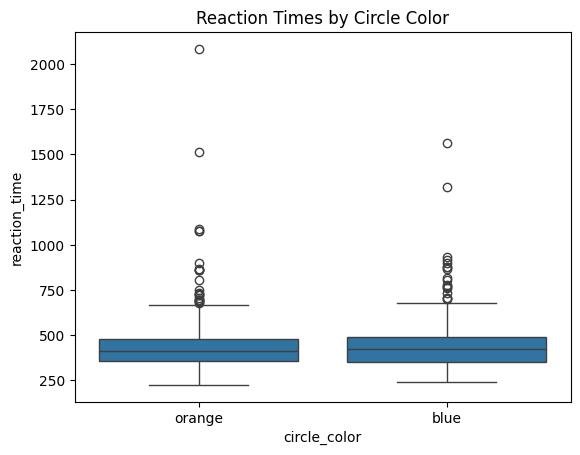

              count        mean         std    min     25%    50%     75%  \
circle_color                                                                
blue          550.0  436.534545  127.070960  242.0  353.25  420.5  491.75   
orange        550.0  434.625455  143.901598  225.0  354.00  412.5  480.50   

                 max  
circle_color          
blue          1560.0  
orange        2084.0  


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by circle color and calculate summary statistics
descriptives = all_data.groupby('circle_color')['reaction_time'].describe()

# Boxplot to visualize reaction times by circle color
sns.boxplot(x='circle_color', y='reaction_time', data=all_data)
plt.title('Reaction Times by Circle Color')
plt.show()

# Print descriptive statistics
print(descriptives)


In [6]:
from scipy.stats import ttest_rel

# Perform paired t-test
group1 = all_data[all_data['circle_color'] == 'orange']['reaction_time'] # Orange circle
group2 = all_data[all_data['circle_color'] == 'blue']['reaction_time'] # Blue circle

t_stat, p_value = ttest_rel(group1, group2)

# Display results
print(f"Paired Samples T-Test:\nT-Statistic = {t_stat}, p-value = {p_value}")


Paired Samples T-Test:
T-Statistic = -0.2520879211177987, p-value = 0.8010674499745879


In [7]:
# Shift the 'circle_color' column to create the 'previous_circle_color' column
all_data['previous_circle_color'] = all_data['circle_color'].shift(1)

# Remove the first trial or row of data from every subject
all_data = all_data.groupby('subject_id').apply(lambda x: x.iloc[1:]).reset_index(drop=True)

# Display the updated dataset
print(all_data.head())


   subject_id  reaction_time circle_color key_pressed accuracy  \
0           1          386.0         blue           f     True   
1           1          366.0         blue           f     True   
2           1          374.0       orange           j     True   
3           1          409.0       orange           j     True   
4           1          445.0         blue           f     True   

  previous_circle_color  
0                orange  
1                  blue  
2                  blue  
3                orange  
4                orange  


In [8]:
np.shape(all_data)

(1078, 6)

In [10]:
# Create a new column 'same_color' to indicate if the previous circle color is the same as the current circle color
all_data['repeat_color'] = all_data['circle_color'] == all_data['previous_circle_color']
all_data.head()

,subject_id,reaction_time,circle_color,key_pressed,accuracy,previous_circle_color,same_color,repeat_color
0,1,386.0,blue,f,True,orange,False,False
1,1,366.0,blue,f,True,blue,True,True
2,1,374.0,orange,j,True,blue,False,False
3,1,409.0,orange,j,True,orange,True,True
4,1,445.0,blue,f,True,orange,False,False


In [11]:
# Perform paired t-test
group1 = all_data[all_data['repeat_color'] == True]['reaction_time']  # Repeat color is True
group2 = all_data[all_data['repeat_color'] == False]['reaction_time']  # Repeat color is False

t_stat, p_value = ttest_rel(group1, group2)

# Display results
print(f"Paired Samples T-Test:\nT-Statistic = {t_stat}, p-value = {p_value}")

# Boxplot visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='repeat_color', y='reaction_time', data=all_data)
plt.title('Reaction Time by Repeat Color')
plt.xlabel('Repeat Color')
plt.ylabel('Reaction Time')
plt.show()


ValueError: unequal length arrays

In [ ]:
import numpy as np

np.shape(group1), np.shape(group2)

((250,), (828,))

Paired Samples T-Test:
T-Statistic = -0.34646111486358394, p-value = 0.7292887933887763

Descriptive Statistics for Group 1 (Repeat Color is True):
count     250.000000
mean      432.492000
std       122.106058
min       252.000000
25%       351.250000
50%       415.000000
75%       488.750000
max      1086.000000
Name: reaction_time, dtype: float64

Descriptive Statistics for Group 2 (Repeat Color is False):
count     250.00000
mean      436.42400
std       130.21365
min       242.00000
25%       361.25000
50%       417.50000
75%       487.50000
max      1560.00000
Name: reaction_time, dtype: float64


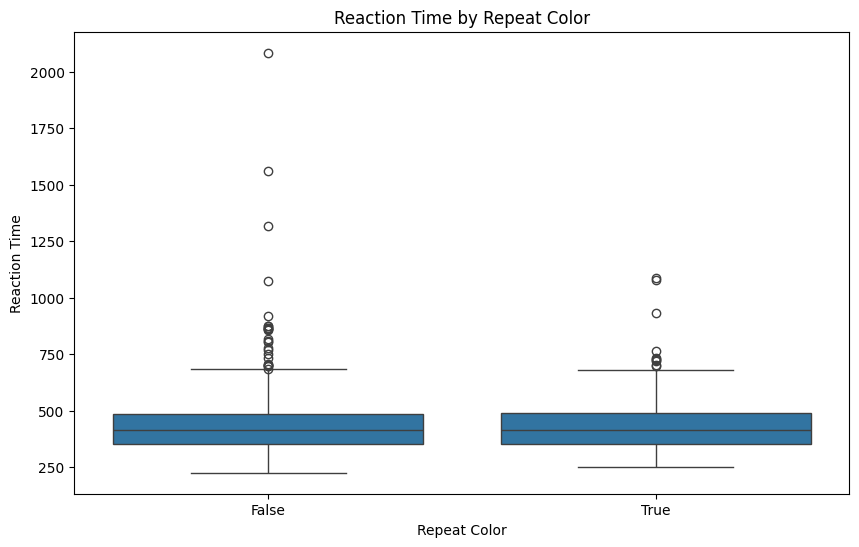

In [16]:
# Randomly sample 250 trials from the 'repeat_color' == False group

group2_sample = all_data[all_data['repeat_color'] == False].sample(n=250, random_state=1)['reaction_time']

t_stat, p_value = ttest_rel(group1, group2_sample)

# Display results
print(f"Paired Samples T-Test:\nT-Statistic = {t_stat}, p-value = {p_value}")

# Get descriptive statistics
group1_desc = group1.describe()
group2_desc = group2_sample.describe()

print("\nDescriptive Statistics for Group 1 (Repeat Color is True):")
print(group1_desc)

print("\nDescriptive Statistics for Group 2 (Repeat Color is False):")
print(group2_desc)

# Boxplot visualization
plt.figure(figsize=(10, 6))
sns.boxplot(x='repeat_color', y='reaction_time', data=all_data)
plt.title('Reaction Time by Repeat Color')
plt.xlabel('Repeat Color')
plt.ylabel('Reaction Time')
plt.show()


                                     sum_sq      df          F        PR(>F)
C(subject_id)                  3.327539e+06    21.0  11.095641  1.533542e-33
C(circle_color)                1.209871e+03     1.0   0.084720  7.710580e-01
C(subject_id):C(circle_color)  2.686349e+05    21.0   0.895760  5.971599e-01
Residual                       1.476631e+07  1034.0        NaN           NaN


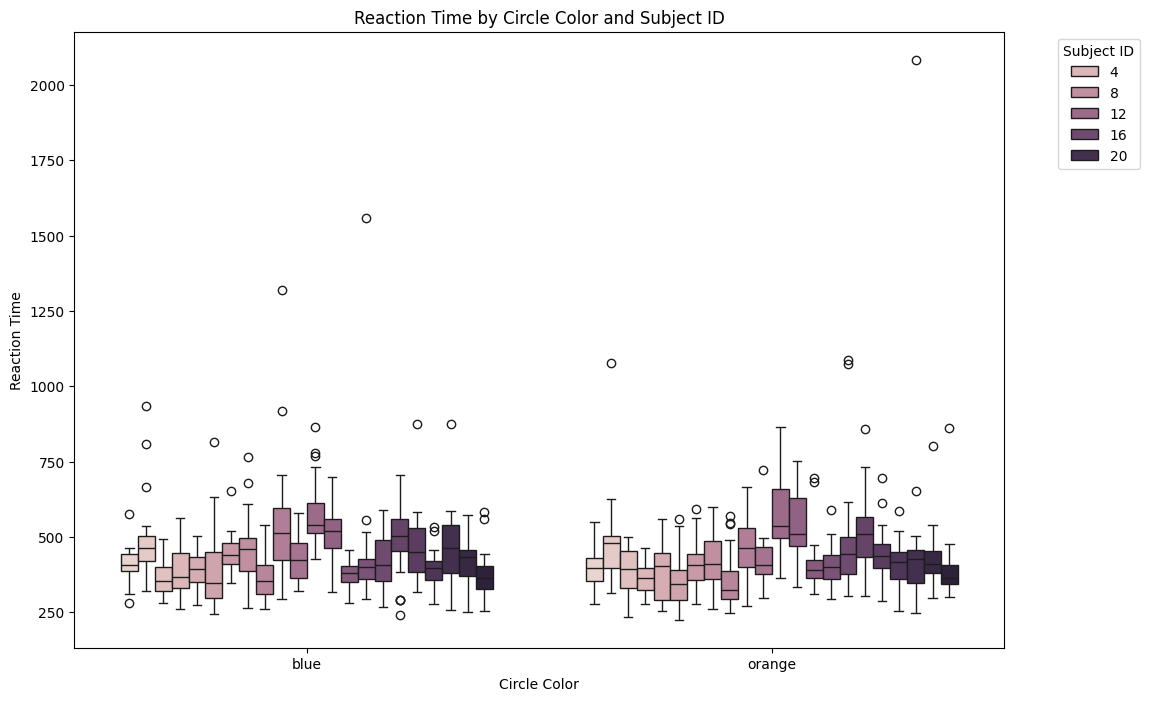

In [17]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import matplotlib.pyplot as plt
import seaborn as sns

# Fit the two-way ANOVA model
model = ols('reaction_time ~ C(subject_id) + C(circle_color) + C(subject_id):C(circle_color)', data=all_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

# Display the ANOVA table
print(anova_table)

# Boxplot visualization
plt.figure(figsize=(12, 8))
sns.boxplot(x='circle_color', y='reaction_time', hue='subject_id', data=all_data)
plt.title('Reaction Time by Circle Color and Subject ID')
plt.xlabel('Circle Color')
plt.ylabel('Reaction Time')
plt.legend(title='Subject ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
